0 1.0000 18.0
100 0.0995 30.0
200 0.0705 90.0
300 0.0576 89.0
400 0.0499 81.0
500 0.0447 200.0
600 0.0408 175.0
700 0.0378 165.0
800 0.0353 130.0
900 0.0333 139.0
1000 0.0316 128.0
1100 0.0301 97.0
1200 0.0289 172.0
1300 0.0277 125.0
1400 0.0267 141.0
1500 0.0258 111.0
1600 0.0250 141.0
1700 0.0242 122.0
1800 0.0236 132.0
1900 0.0229 135.0
2000 0.0224 142.0
2100 0.0218 131.0
2200 0.0213 120.0
2300 0.0208 134.0
2400 0.0204 126.0
2500 0.0200 131.0
2600 0.0196 146.0
2700 0.0192 149.0
2800 0.0189 179.0
2900 0.0186 123.0
3000 0.0183 118.0
3100 0.0180 132.0
3200 0.0177 146.0
3300 0.0174 130.0
3400 0.0171 139.0
3500 0.0169 166.0
3600 0.0167 159.0
3700 0.0164 95.0
3800 0.0162 174.0
3900 0.0160 116.0
4000 0.0158 125.0
4100 0.0156 87.0
4200 0.0154 169.0
4300 0.0152 137.0
4400 0.0151 122.0
4500 0.0149 91.0
4600 0.0147 84.0
4700 0.0146 84.0
4800 0.0144 65.0
4900 0.0143 73.0
5000 0.0141 107.0
5100 0.0140 127.0
5200 0.0139 124.0
5300 0.0137 115.0
5400 0.0136 85.0
5500 0.0135 116.0
5600 0.0134 200.0


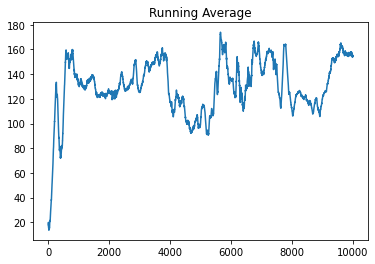

In [1]:
import gym                               #openAI gym的库
import numpy as np                       #利用numpy库进行向量和矩阵的运算
from gym import wrappers                  # 这个库可以帮我们把游戏的视频变成音频格式
import matplotlib.pyplot as plt          #visualization

env= gym.make('CartPole-v0')              #选择训练的游戏
MAXSTATE = 10**4                         #possibille discrete state
GAMMA = 0.9                               #parameters in the Q-learning mathematics：
ALPHA = 0.01                              #parameters in the Q-learning mathematics：learning rate

def max_dict(d):                          #iterate a dictionary and return the max_key and its value
                                          #Goal: to find the action expecting the maxium reward for a given state
    max_v = float('-inf')                 #inf:infinity ∞ 
   
    for key,val in d.items():
        if val >max_v:
            max_v = val
            max_key = key
    return max_key,max_v

def create_bins():                         #how to break a continous space into discrete space (because the game is continous)
    bins = np.zeros((4,10))                # 4 parameters in the observation
    #linspace函数可以在指定的范围(start到stop)内返回1个数组(这里的数组指ndarray数组),这个数组包含了num个均匀间隔的样本。    
    bins[0] = np.linspace(-4.8,4.8,10)     # cart position      
    bins[1] = np.linspace(-5,5,10)         # cart velocity
    bins[2] = np.linspace(-0.418,0.418,10)  # pole angle
    bins[3] = np.linspace(-5,5,10)         # pole velocity
    return bins

def assign_bins(observation,bins):                         #Given a specific state and what bin will it fall into（continious->digital）      
    state = np.zeros(4)                                    #state是一个四维向量，每一个向量都标记着这个state落到的bin的下标
    for i in range(4):                                      
        state[i] = np.digitize(observation[i],bins[i])     #参数到底落在了10个桶中的哪一个？ （想想正态分布小球的图片）返回的是落在pin的数组下标
    return state                                 

def get_state_as_string(state): #将每个状态都字符串化 方便字典编码？其实我也不知道方便在哪里——梁永杰
    #print(state[0],'\n')
    #print(state[1],'\n')
    #print(state[2],'\n')
    #print(state[3],'\n')
    string_state = ''.join(str(int(e)) for e in state)
    return string_state

def get_all_states_as_string():                             #这个函数生成一个[0000,9999]的整数转字符串序列，用于状态编码
    states = []
    for i in range(MAXSTATE):
 
        states.append(str(i).zfill(4))                     #fill函数内置于str类，用于高位补零
    return states

def initialize_Q():
    Q = {}                                                 #此处声明Q是一个dict类型(字典)        
                                                           #Q可以理解为是 action-state 与 expected reward 的映射表
    all_states = get_all_states_as_string()
    for state in all_states:
        Q[state] = {}                                      #每一个Q[state] 也是一个字典
        for action in range(env.action_space.n):           #对于在每个state里面，采取的每一个action都记录下来
            Q[state][action] = 0                           #这个不是二维数组，而是： 对于Q而言，以key=state索引，对于Q[state]而言以[action]索引
    return Q

def play_one_game(bins , Q , eps = 0.5):
    observation = env.reset()
    done = False
    cnt =0                                                 #number of moves in an episode
    state = get_state_as_string(assign_bins(observation,bins))
    total_reward = 0
                                                            #epsilon greedy algorithm
    while not done:
        cnt = 1
        if np.random.uniform() < eps:                       #如果随机数p（0~1）小于ε，那么在action空间中随机抽样                    
            act = env.action_space.sample()                
        else:                                               #如果随机数p（0~1）大于ε，那么只选取当前状态下最大收益的action
            act = max_dict(Q[state])[0]  
                                                            #随着时间的流逝，最好的action会越来越频繁地被选择，因为选择它将得到更多的收益。
        observation,reward,done,_ = env.step(act)           #将greedy算法抽取的动作与环境交互
        
        total_reward += reward                              #将奖励记录在总奖励里面
        
        if done and cnt < 200:                              #未理解：由于最大奖励是200，所以-300的reward将会是灾难性的，作为fallover的惩罚
            reward = -300                                   
            
        state_new = get_state_as_string(assign_bins(observation,bins))#将刚才与环境交互得到的observation encoding to statecode
        
        al,max_q_slal = max_dict(Q[state_new])               #找到当前状态下最优的action 以及对应的未来预测奖励值
        Q[state][act] += ALPHA*(reward+GAMMA*max_q_slal - Q[state][act])
        state,act = state_new,al
    return total_reward, cnt
        
        
def play_many_games(bins,N=10000):
    Q = initialize_Q()
    
    length = [] #用于跟踪每一个episode走的长度
    reward = [] #用于跟踪每一个episode得到的reward
    for n in range(N):
        eps = 1.0/np.sqrt(n+1)       #一个递减的epsilon
        episode_reward , episode_length = play_one_game(bins,Q,eps)
        
        if n%100==0:
            print(n,'%.4f'%eps,episode_reward)
        length.append(episode_length)
        reward.append(episode_reward)
    return length,reward

def plot_running_avg(totalrewards):                                        #可视化
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(totalrewards[max(0,t-100):(t+1)])        #对一个矩阵求均值
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()
        
if __name__ == '__main__':
    bins = create_bins()
    episode_lengths,episode_rewards = play_many_games(bins)
    plot_running_avg(episode_rewards)
    
           
            